## Refit Models
---

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import src.monitoring.refit as refit
import src.monitoring.governance as gvrn
import src.monitoring.monitoring as mntr
import src.monitoring.utils as mu

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
mmonth = "202103"
s3_base_path = f"s3://sofi-data-science/jxu/money-risk-models/customer-risk-model/monitor/{mmonth}"

train_df = pd.read_parquet(os.path.join(s3_base_path, "dev_train_20190201_20201130.parquet"))
test_df = pd.read_parquet(os.path.join(s3_base_path, "dev_test_20201201.parquet"))

<AxesSubplot:>

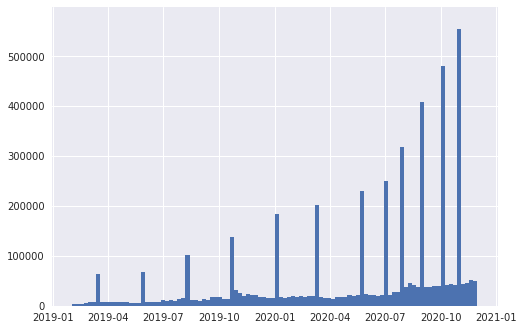

In [3]:
train_df.sample_date.hist(bins=100)
test_df.sample_date.hist(bins=10)

### Preprocess and get some stats
---

In [4]:
train_df = mu.preprocess(train_df)
test_df = mu.preprocess(test_df)

In [5]:
train_df.indeterminate.value_counts()

False    2627855
True     2085333
Name: indeterminate, dtype: int64

In [6]:
train_df.target.value_counts(normalize=True), test_df.target.value_counts(normalize=True)

(False    0.966724
 True     0.033276
 Name: target, dtype: float64,
 False    0.988956
 True     0.011044
 Name: target, dtype: float64)

In [7]:
train_df.indeterminate.value_counts(normalize=True), test_df.indeterminate.value_counts(normalize=True)

(False    0.557554
 True     0.442446
 Name: indeterminate, dtype: float64,
 True     0.800373
 False    0.199627
 Name: indeterminate, dtype: float64)

### Fit Models
---

In our unfortunate naming: w_ind means with indeterminant that further translate to:
* We trained the model including the indeterminant data.

In [8]:
# with indeterminant
clf_w_ind = refit.train(train_df,
                  date_col="sample_date",
                  indeterminate_col=None)

modeling_df last date: 2020-11-30 00:00:00
15556
target counts
False    4556350
True      156838
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignore

In [9]:
# without indeterminant
clf_wo_ind = refit.train(train_df,
                  date_col="sample_date",
                  indeterminate_col="indeterminate")

data statistics (4713188, 42)
indeterminate removed!
data statistics after removing indeterminate (2627855, 42)
modeling_df last date: 2020-11-30 00:00:00
15556
target counts
False    2614131
True       13724
Name: target, dtype: int64
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=116, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=116
[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Cu

In [10]:
clf_w_ind, clf_wo_ind

(LGBMClassifier(bagging_seed=15556, boosting='gbdt',
                categorical_feature=[39, 40, 41], feature_fraction=0.8,
                lambda_l1=16, lambda_l2=10, learning_rate=0.03, max_depth=4,
                metric='auc', min_data_in_leaf=116, num_iterations=1400,
                num_leaves=15, objective='binary',
                scale_pos_weight=29.051314094798453, seed=15556, subsample=0.94,
                tree_learner='feature', verbosity=1),
 LGBMClassifier(bagging_seed=15556, boosting='gbdt',
                categorical_feature=[39, 40, 41], feature_fraction=0.8,
                lambda_l1=16, lambda_l2=10, learning_rate=0.03, max_depth=4,
                metric='auc', min_data_in_leaf=116, num_iterations=1400,
                num_leaves=15, objective='binary',
                scale_pos_weight=190.47879626930924, seed=15556, subsample=0.94,
                tree_learner='feature', verbosity=1))

In [11]:
import pickle as pkl

with open("../../artifacts/refitting-202021Q1/customer_risk_20201130_w_ind.pkl", "wb") as f:
    pkl.dump(clf_w_ind, f)
    
with open("../../artifacts/refitting-202021Q1/customer_risk_20201130_wo_ind.pkl", "wb") as f:
    pkl.dump(clf_wo_ind, f)

### Make Predictions, Scores, and RGs

In [12]:
prev_model_s3_key = "jxu/money-risk-models/customer-risk-model/models/customer_risk_target_no_giact_time_since_last_link.pkl"
prev_model = mu.read_pickle_from_s3("sofi-data-science", prev_model_s3_key)

In [13]:
train_df["pred_20191231"] = prev_model.predict_proba(train_df[prev_model.feature_name_])[:,1]
train_df["score_20191231"] = mu.scale_scores(train_df["pred_20191231"])

train_df["pred_20201130_wo_ind"] = clf_wo_ind.predict_proba(train_df[clf_wo_ind.feature_name_])[:,1]
train_df["score_20201130_wo_ind"] = mu.scale_scores(train_df["pred_20201130_wo_ind"])

train_df["pred_20201130_w_ind"] = clf_w_ind.predict_proba(train_df[clf_w_ind.feature_name_])[:,1]
train_df["score_20201130_w_ind"] = mu.scale_scores(train_df["pred_20201130_w_ind"])

In [14]:
test_df["pred_20191231"] = prev_model.predict_proba(test_df[prev_model.feature_name_])[:,1]
test_df["score_20191231"] = mu.scale_scores(test_df["pred_20191231"])

test_df["pred_20201130_wo_ind"] = clf_wo_ind.predict_proba(test_df[clf_wo_ind.feature_name_])[:,1]
test_df["score_20201130_wo_ind"] = mu.scale_scores(test_df["pred_20201130_wo_ind"])

test_df["pred_20201130_w_ind"] = clf_w_ind.predict_proba(test_df[clf_w_ind.feature_name_])[:,1]
test_df["score_20201130_w_ind"] = mu.scale_scores(test_df["pred_20201130_w_ind"])


In [15]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)])

train_df['rg_20191231'] = get_risk_groups(train_df.score_20191231)
train_df['rg_20201130_wo_ind'] = get_risk_groups(train_df.score_20201130_wo_ind)
train_df['rg_20201130_w_ind'] = get_risk_groups(train_df.score_20201130_w_ind)

In [16]:
test_df['rg_20191231'] = get_risk_groups(test_df.score_20191231)
test_df['rg_20201130_wo_ind'] = get_risk_groups(test_df.score_20201130_wo_ind)
test_df['rg_20201130_w_ind'] = get_risk_groups(test_df.score_20201130_w_ind)

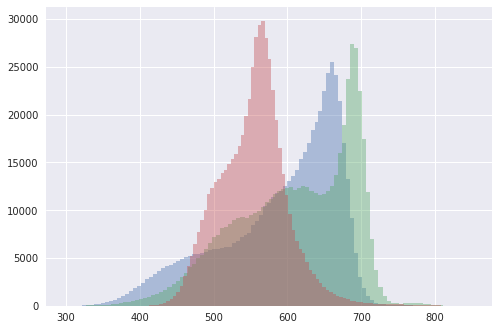

In [17]:
from rdsutils.post_implementation_testing import plot_score_dist, get_psi, get_overlap_and_diff

for col in ["score_20191231", "score_20201130_wo_ind", "score_20201130_w_ind"]:
    test_df[col].hist(bins=100, alpha=0.4, label=col)

In [18]:
def scale_scores_(predictions,
                 alpha = 631.9455383610933, 
                 beta = 30.812519272450654):
    """
    Convert probability to score.
    """
    try:
        assert ((predictions >= 0) & (predictions <= 1)).all(), 'probability must be in range [0,1]'
    except AssertionError:
        raise
    # Minimum and maximum values for validation
    MINIMUM = 300
    MAXIMUM = 850

    score = np.minimum(np.maximum(np.log(predictions / (1 - predictions)) * beta + alpha, MINIMUM), MAXIMUM)
   
    return score

In [19]:
x = [743.17590331,  59.30207539]

alpha, beta = x

train_df["score_rescaled_20201130_w_ind"] = scale_scores_(
    train_df.pred_20201130_w_ind, alpha=alpha, beta=beta)
train_df['rg_rescaled_20201130_w_ind'] = get_risk_groups(train_df.score_rescaled_20201130_w_ind)

In [20]:
x = [743.17590331,  59.30207539]

alpha, beta = x

test_df["score_rescaled_20201130_w_ind"] = scale_scores_(
    test_df.pred_20201130_w_ind, alpha=alpha, beta=beta)
test_df['rg_rescaled_20201130_w_ind'] = get_risk_groups(test_df.score_rescaled_20201130_w_ind)

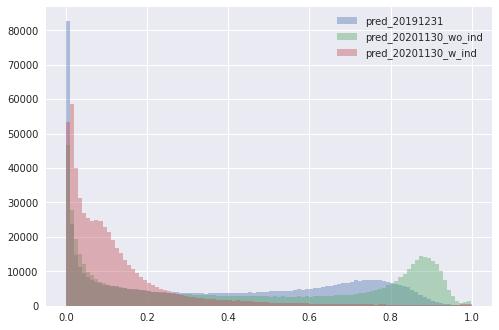

In [21]:
for col in ["pred_20191231", "pred_20201130_wo_ind", 
            "pred_20201130_w_ind"]:
    test_df[col].hist(bins=100, alpha=0.4, label=col)
plt.legend()

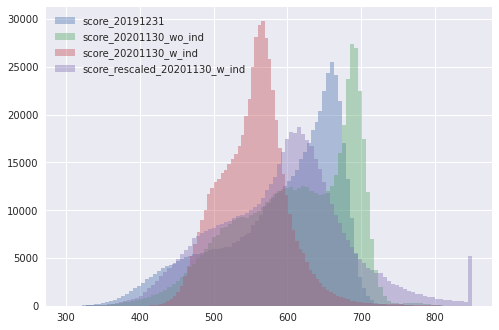

In [22]:
for col in ["score_20191231", "score_20201130_wo_ind", 
            "score_20201130_w_ind", "score_rescaled_20201130_w_ind"]:
    test_df[col].hist(bins=100, alpha=0.4, label=col)
plt.legend()

In [23]:
test_df.to_parquet(os.path.join(s3_base_path, "dev_test_20201201_scored.parquet"))

In [24]:
train_df.to_parquet(os.path.join(s3_base_path, "dev_train_20201201_scored.parquet"))

### Fit a model without 30d features